<a href="https://colab.research.google.com/github/ArmandDS/blog-post/blob/main/gpt2_twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook is for the blogpost: **How to create a tweet generator with GPT-2** 

That you can found in my blog https://armandolivares.tech/2022/09/16/how-to-create-a-tweet-generator-with-gpt-2/

# Install the packages

In [ ]:
!pip -qq install transformers

In [6]:
!pip -qq install datasets

# load the necessary packages

In [7]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random
from datasets import Dataset


import matplotlib.pyplot as plt
# % matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import  GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling, TrainingArguments, Trainer, \
                         GPT2LMHeadModel, pipeline

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Check for the GPU

In [8]:
!nvidia-smi

Sat Sep 17 14:59:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the data

In [38]:
# load into a data frame
filename = "/content/tweets_data.csv"
df = pd.read_csv (filename)  
print(df.head(2))

   Unnamed: 0                   id      conversation_id    created_at  \
0           0  1477789070268981252  1477789070268981252  1.641167e+12   
1           1  1477788855118057474  1477775375228825600  1.641167e+12   

                  date  timezone  place  \
0  2022-01-02 23:49:05       0.0    NaN   
1  2022-01-02 23:48:13       0.0    NaN   

                                               tweet language  \
0  Navy Awards Winners of Artificial Intelligence...       en   
1  @pmddomingos I followed you to learn about mac...       en   

                                            hashtags  ... retweet_id  \
0  ['artificialintelligence', 'ai', 'datascience'...  ...        NaN   
1                                                 []  ...        NaN   

                                            reply_to  retweet_date translate  \
0                                                 []           NaN       NaN   
1  [{'screen_name': 'pmddomingos', 'name': 'Pedro...           NaN       NaN 

In [40]:
print(df.columns)

Index(['Unnamed: 0', 'id', 'conversation_id', 'created_at', 'date', 'timezone',
       'place', 'tweet', 'language', 'hashtags', 'cashtags', 'user_id',
       'user_id_str', 'username', 'name', 'day', 'hour', 'link', 'urls',
       'photos', 'video', 'thumbnail', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'search', 'near', 'geo', 'source',
       'user_rt_id', 'user_rt', 'retweet_id', 'reply_to', 'retweet_date',
       'translate', 'trans_src', 'trans_dest', 'tweet_c', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1'],
      dtype='object')


Select only the tweet column

In [10]:
df = df[['tweet']].astype(str)

Drop missing values, if any

In [11]:
df.dropna(inplace=True)
df.shape

(20655, 1)

Check the len of the tweets distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


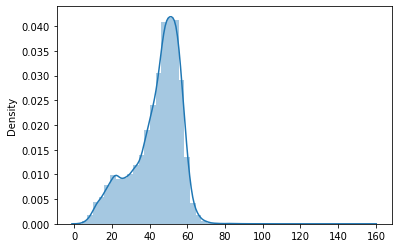

In [12]:
doc_lengths = []

for elem in df['tweet']:

    # get rough token count distribution
    tokens = nltk.word_tokenize(elem)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.displot(doc_lengths)

In [41]:
print(np.average(doc_lengths))

43.928201404018395


# Load the Tokenizer

In [15]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', 
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>') #gpt2-medium


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


## Adapt the data for training

In [17]:
batch_size = 8

In [18]:
# This is our "training prompt" that we want GPT2 to recognize and learn
training_examples = f'<|startoftext|> ' + df['tweet'] + '<|endoftext|>'

print(training_examples[0])

<|startoftext|> Navy Awards Winners of Artificial Intelligence Challenge - MilitarySpot  Read more here:  https://t.co/yQYngnLMBP  #ArtificialIntelligence #AI #DataScience #100DaysOfCode #Python #MachineLearning #BigData #DeepLearning #NLP #Robots #IoT<|endoftext|>


In [44]:
task_df = pd.DataFrame({'text': training_examples})

task_df.head(5)

,text
0,<|startoftext|> Navy Awards Winners of Artific...
1,<|startoftext|> @pmddomingos I followed you to...
2,<|startoftext|> Modern Deep Learning in Python...
3,<|startoftext|> mildly meta take — this guy is...
4,<|startoftext|> Botanical painting #aiart #Ma...


Transform the data to a hg dataset

In [20]:
from datasets import Dataset

tweet_data = Dataset.from_pandas(task_df)  # turn a pandas DataFrame into a Dataset

def preprocess(example):  # tokenize our text but don't pad because our collator will pad for us dynamically
    return tokenizer( example['text'], truncation=True)

tweet_data = tweet_data.map(preprocess, batched=False)

tweet_data = tweet_data.train_test_split(train_size=.8)

  0%|          | 0/20655 [00:00<?, ?ex/s]

Instanciate the data collator

In [21]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Load the GPT2 Model

In [22]:
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

Downloading:   0%|          | 0.00/548M [00:00<?, ?B/s]

Embedding(50259, 768)

Before trainig let's check how it complete the text

In [23]:
device = torch.device("cuda")
# model = gpt2
model.to(device)
model.eval()

prompt = "<|startoftext|> I wonder"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 300,
                                top_p=0.98, 
                                num_return_sequences=10,
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   314,  4240]], device='cuda:0')
0:  I wonder


1:  I wonder


2:  I wonder


3:  I wonder


4:  I wonder


5:  I wonder


6:  I wonder


7:  I wonder


8:  I wonder


9:  I wonder




as you can see it ony repeat the tokens

## Configure the network parameters

In [24]:
epochs = 2
learning_rate = 2e-4
warmup_steps = 1e2
epsilon = 1e-8

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )


total_steps = len(tweet_data["train"]) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [25]:
!rm -vr /content/tweets

rm: cannot remove '/content/tweets': No such file or directory


In [26]:
seed_val = 38

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [27]:
training_args = TrainingArguments(
    output_dir="./tweets",
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs= epochs, # number of training epochs
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size,  # batch size for evaluation
    load_best_model_at_end=True,
    logging_steps=5,
    log_level='info',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate= learning_rate,
    warmup_steps=warmup_steps,
    seed= 38,
    
     
     
 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tweet_data["train"],
    eval_dataset=tweet_data["test"],
    data_collator=data_collator,
    optimizers = (optimizer, scheduler),
)

# trainer.evaluate()

# And train:

In [28]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16524
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4132


Epoch,Training Loss,Validation Loss
1,2.654800,2.422699


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4131
  Batch size = 8
Saving model checkpoint to ./tweets/checkpoint-2066
Configuration saved in ./tweets/checkpoint-2066/config.json
Model weights saved in ./tweets/checkpoint-2066/pytorch_model.bin


Epoch,Training Loss,Validation Loss
1,2.654800,2.422699
2,1.877800,2.304435


The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4131
  Batch size = 8
Saving model checkpoint to ./tweets/checkpoint-4132
Configuration saved in ./tweets/checkpoint-4132/config.json
Model weights saved in ./tweets/checkpoint-4132/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./tweets/checkpoint-4132 (score: 2.3044352531433105).


TrainOutput(global_step=4132, training_loss=2.7172286897061064, metrics={'train_runtime': 1292.0062, 'train_samples_per_second': 25.579, 'train_steps_per_second': 3.198, 'total_flos': 1953451892736000.0, 'train_loss': 2.7172286897061064, 'epoch': 2.0})

In [ ]:
#(\#\w+\s+)*\#\w+$

# Evalute the results

In [29]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text, __index_level_0__. If text, __index_level_0__ are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 4131
  Batch size = 8


{'eval_loss': 2.3044352531433105,
 'eval_runtime': 43.0305,
 'eval_samples_per_second': 96.002,
 'eval_steps_per_second': 12.015,
 'epoch': 2.0}

In [47]:
device = torch.device("cuda")

model.eval()

prompt = "<|startoftext|> I wonder"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=20, 
                                max_length = 70,
                                top_p=0.98, 
                                num_return_sequences=10,
                                temperature=0.95

                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257,   314,  4240]], device='cuda:0')
0:  I wonder if these #AI researchers have their full set of data to back up any of these claims.    If so, would #MachineLearning #art really need a ‘science-based' filter?


1:  I wonder if this is the time we are talking about #AI?   #DataScience #MachineLearning


2:  I wonder if this isn't all you can see? #digitaltransformation #MachineLearning #AI #Python #DataScience #BigData #DeepLearning #IoT #100DaysOfCode #5G #robots #tech #ArtificialIntelligence #NLP #cloud #4IR #cybersecurity  https://t


3:  I wonder if you were to code in machine language, language would you be able to do it?


4:  I wonder what the future holds? #AI #MachineLearning #DataScience #Bigdata #Analytics #Robotics  https://t.co/oZkYn7q2k0


5:  I wonder if there is a #MachineLearning #Algorithm for predicting the time politicians will spend in their office (and how they will spend it)  https://t.co/kz1kzcWfkq


6:  I wonder if you are using R, like I would, to

It seems pretty goods, results, realist, we see that the model add the hashtags and even fake links.
